## Makeplot for Beam Walk

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from obspy import UTCDateTime

In [2]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.load_beam_wander_data_v2 import __load_beam_wander_data
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.find_max_min import __find_max_min

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename == 'teide':
    root_path = '/home/sysopromy/'
    data_path = '/freenas-ffb-01/'
    archive_path = '/freenas-ffb-01/'
    bay_path = '/bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

### Load Configuration

In [4]:
config = {}

# specify cameras (designed for 4 cameras)
config['cameras'] = ['00', '03', '07', '05']

# path to beam walk data
config['path_to_data'] = archive_path+f"ids/"

# path to automatic beam images
config['path_to_images'] = archive_path+"ids/"

# path to figure output
config['path_to_figs'] = archive_path+f"romy_html_monitor/figures/"

# conversion from pixel to mm
config['conversion'] = {#"00":1.67e-3,
                        "00":5.3e-3,
                        "01":5.3e-3,
                        "03":5.3e-3,
                        "05":5.3e-3,
                        "07":5.3e-3,
                       }

# conversion from pixel to mm
config['chipsize'] = {
    # "00": {"xmax": 2748, "ymax": 3840},
    "00": {"ymax": 1024, "xmax": 1024},
    "01": {"ymax": 1024, "xmax": 1280},
    "03": {"ymax": 1024, "xmax": 1280},
    "05": {"ymax": 1024, "xmax": 1280},
    "07": {"ymax": 1024, "xmax": 1280},
}

# colors
config['colors'] = {"00":"tab:blue",
                    "01":"tab:orange",
                    "03":"tab:red",
                    "05":"tab:green",
                    "07":"tab:purple",
                    }

# specify length of time interval to show
config['time_interval'] = 14 # days

# config['last_reset'] = UTCDateTime("2024-10-01 14:00")
# config['last_reset'] = UTCDateTime("2024-10-09 13:00")
# config['last_reset'] = UTCDateTime("2025-04-14 15:00")
config['last_reset'] = UTCDateTime("2025-07-03 00:00")

# define time interval
config['tend'] = UTCDateTime().now()
if abs(config['tend'] - config['last_reset']) > config['time_interval'] * 86400:
    config['tbeg'] = config['tend'] - config['time_interval'] * 86400
else:
    config['tbeg'] = config['last_reset']

# resets
config['resets'] = {'00':"2024-09-12 12:00",
                    }


In [5]:
def __get_latest_filename(path):
    from glob import glob
    from os.path import getctime

    # list of all files
    list_of_files = glob(path+"*.png")

    # extract latest file
    latest_file = max(list_of_files, key=getctime)

    # split string
    _tmp = latest_file.split("/")[-1].split("_")

    # format datestring
    datetime = f"{_tmp[0][:4]}-{_tmp[0][4:6]}-{_tmp[0][6:8]} {_tmp[1][:2]}:{_tmp[1][2:4]}:{_tmp[1][4:6]} UTC"

    return latest_file, datetime

In [6]:
def __adjust_times(df0, cam0):

    # add utc object
    df0.loc[:, 'time_utc'] = [UTCDateTime(tl) for tl in df0.time]

    # cut to time period
    df0 = df0[(df0.time_utc >= config['tbeg']) & (df0.time_utc <= config['tend'])]

    # adjust strartime by resets
    if cam0 in config['resets']:
        df0 = df0[df0.time_utc > UTCDateTime(config['resets'][cam0])]

    df0.reset_index(drop=True, inplace=True)

    # add relative times
    df0.loc[:, 'time_sec'] = df0.time_utc - config['tbeg']

    return df0

In [7]:
def __convert_and_reduce(df0, conversion_factor):

    from functions.reduce import __reduce

    keys_to_convert = ["y_idx", "x_idx", "y", "x", "x_sig", "y_sig"]

    for k in keys_to_convert:
        df0.loc[:, k] = df0[k].values * conversion_factor

    # to micrometer
    df0.loc[:, 'x_um_rel'] = __reduce(df0.x.values * 1e3, 5)
    df0.loc[:, 'y_um_rel'] = __reduce(df0.y.values * 1e3, 5)

    df0.loc[:, 'x_um_sig'] = df0.x_sig.values * 1e3
    df0.loc[:, 'y_um_sig'] = df0.y_sig.values * 1e3

    df0.loc[:, 'x_um_var'] = df0.x_var.values * 1e3
    df0.loc[:, 'y_um_var'] = df0.y_var.values * 1e3

    df0.reset_index(drop=True, inplace=True)

    return df0

In [8]:
def __filter(df0):

    n1 = df0.size

    # remove bad estimates
    df0 = df0[df0['y_sig_var'] != np.inf]
    df0 = df0[df0['x_sig_var'] != np.inf]
    print(df0.shape)

    # when intensity is super low, there is a black image
    df0 = df0[df0['amp'] > 10]

    # when intensity is super high or saturated, there is likely a MLTI boost
    df0['large_amp'] = df0['amp'] > 255

    if df0.size != n1:
        df0.reset_index(inplace=True)

    return df0

### Load MLTI

In [9]:
mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [10]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [11]:
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

### Load Beam Walk Data

In [12]:
ids = {}

for _cam in config['cameras']:
    try:
        ids[_cam] = __load_beam_wander_data(config['tbeg'].date,
                                            config['tend'].date,
                                            config['path_to_data'],
                                            _cam
                                           )
    except Exception as e:
        print(_cam, e)

errors 00:  ['data00/20250703.pkl']
errors 03:  ['data03/20250703.pkl']
errors 07:  ['data07/20250703.pkl']
errors 05:  ['data05/20250703.pkl']


### Processing

In [13]:
for _cam in config['cameras']:

    try:
        # adjust times
        ids[_cam] = __adjust_times(ids[_cam], _cam)

        # perfrom conversions
        ids[_cam] = __convert_and_reduce(ids[_cam], config['conversion'][_cam])

        # filter bad data
        ids[_cam] = __filter(ids[_cam])

    except Exception as e:
        print(e)


'DataFrame' object has no attribute 'time'
'DataFrame' object has no attribute 'time'
'DataFrame' object has no attribute 'time'
'DataFrame' object has no attribute 'time'


### Load LXX Log

In [13]:
# load maintenance log
lxx = __load_lxx(config['tbeg'], config['tend'], archive_path)

# get intervals
lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Plotting

In [16]:
def __makeplot():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    tscale, tunit = 1/86400, "days"

    font = 12

    Nrow, Ncol = 8, 8

    fig = plt.figure(figsize=(18, 10))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.2)

    ax0 = fig.add_subplot(gs[0:4, 0:4])
    ax1 = fig.add_subplot(gs[4:8, 0:4])

    ax2 = fig.add_subplot(gs[0:2, 4:6])
    ax3 = fig.add_subplot(gs[2:4, 4:6])
    ax4 = fig.add_subplot(gs[4:6, 4:6])
    ax5 = fig.add_subplot(gs[6:8, 4:6])

    ax6 = fig.add_subplot(gs[0:2, 6:8])
    ax7 = fig.add_subplot(gs[2:4, 6:8])
    ax8 = fig.add_subplot(gs[4:6, 6:8])
    ax9 = fig.add_subplot(gs[6:8, 6:8])

    axes00 = [ax0, ax1]
    axes11 = [ax2, ax3, ax4, ax5]
    axes22 = [ax6, ax7, ax8, ax9]

    # _______________________________________________________

    _data = []
    for _cam in config['cameras']:

        try:
            _df = ids[_cam]

            ax0.scatter(ids[_cam].loc[~ids[_cam]['large_amp'], 'time_sec']*tscale,
                        ids[_cam].loc[~ids[_cam]['large_amp'], 'y_um_rel'],
                        s=1,
                        color=config['colors'][_cam],
                        label=f"IDS-{_cam}"
                       )
            ax0.scatter(ids[_cam].loc[ids[_cam]['large_amp'], 'time_sec']*tscale,
                        ids[_cam].loc[ids[_cam]['large_amp'], 'y_um_rel'],
                        s=1,
                        alpha=0.3,
                        color=config['colors'][_cam],
                       )

            _data.append(_df.y_um_rel.values)

        except Exception as e:
            print(e)

    try:
        ax0.set_ylim(__find_max_min(_data, pp=99))
    except Exception as e:
        print(e)

    ax0.grid(color="gray", alpha=0.4, ls="--")
    ax0.legend(ncol=4, markerscale=3)

    ax0.set_xticklabels([])

    ax0.set_ylabel("relative Y-Position ($\mu$m)", fontsize=font)

    # _______________________________________________________

    _data = []
    for _cam in config['cameras']:

        try:
            _df = ids[_cam]

            ax1.scatter(ids[_cam].loc[~ids[_cam]['large_amp'], 'time_sec']*tscale,
                        ids[_cam].loc[~ids[_cam]['large_amp'], 'x_um_rel'],
                        s=1,
                        color=config['colors'][_cam],
                        label=f"IDS-{_cam}"
                       )
            ax1.scatter(ids[_cam].loc[ids[_cam]['large_amp'], 'time_sec']*tscale,
                        ids[_cam].loc[ids[_cam]['large_amp'], 'x_um_rel'],
                        s=1,
                        alpha=0.3,
                        color=config['colors'][_cam],
                       )
            _data.append(_df.x_um_rel.values)


        except Exception as e:
            print(e)

    try:
        ax1.set_ylim(__find_max_min(_data, pp=99))
    except Exception as e:
        print(e)

    ax1.grid(color="gray", alpha=0.4, ls="--")
    ax1.legend(ncol=4, markerscale=3)

    ax1.set_ylabel("relative X-Position ($\mu$m)", fontsize=font)
    ax1.set_xlabel(f"Time ({tunit}) since {config['tbeg'].date}  {str(config['tbeg'].time)[:10]} UTC", fontsize=font)

    # _______________________________________________________

    for ax, _cam in zip(axes11, config['cameras']):

        try:
            _df = ids[_cam]

            ax.scatter(
                _df.x*config['conversion'][_cam],
                _df.y*config['conversion'][_cam],
                c=_df.time_sec,
                s=1
            )

            # ax.set_xlim(0, config['chipsize'][_cam]['xmax']*config['conversion'][_cam])
            # ax.set_ylim(0, config['chipsize'][_cam]['ymax']*config['conversion'][_cam])

        except Exception as e:
            print(e)

        ax.grid(color="gray", alpha=0.4, ls="--")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # _______________________________________________________

    for ax, _cam in zip(axes22, config['cameras']):

        try:
            _imagedir = f"data{_cam}/outfigs/"

            _image, _datetime = __get_latest_filename(config['path_to_images'] + _imagedir)

            try:
                ax.imshow(plt.imread(_image))
            except:
                print(f" -> failed to load image for {_cam}")

            ax.set_title(f"IDS-{_cam} | {_datetime}", pad=1)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        except:
            print(f" -> failed image for {_cam}")
    
    for ax in axes11+axes22:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax0.set_title(f"Beam Walk Monitor (last reset: {config['last_reset'].date} {str(config['last_reset'].time)[:10]} UTC)", pad=1)
    # plt.show();
    return fig

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


'large_amp'
'large_amp'
'large_amp'
'large_amp'
min() arg is an empty sequence
'large_amp'
'large_amp'
'large_amp'
'large_amp'
min() arg is an empty sequence
'DataFrame' object has no attribute 'x'
'DataFrame' object has no attribute 'x'
'DataFrame' object has no attribute 'x'
'DataFrame' object has no attribute 'x'
 -> failed image for 05


PermissionError: [Errno 13] Permission denied: '/home/andbro/freenas/romy_html_monitor/figures/html_beamwalk.png'

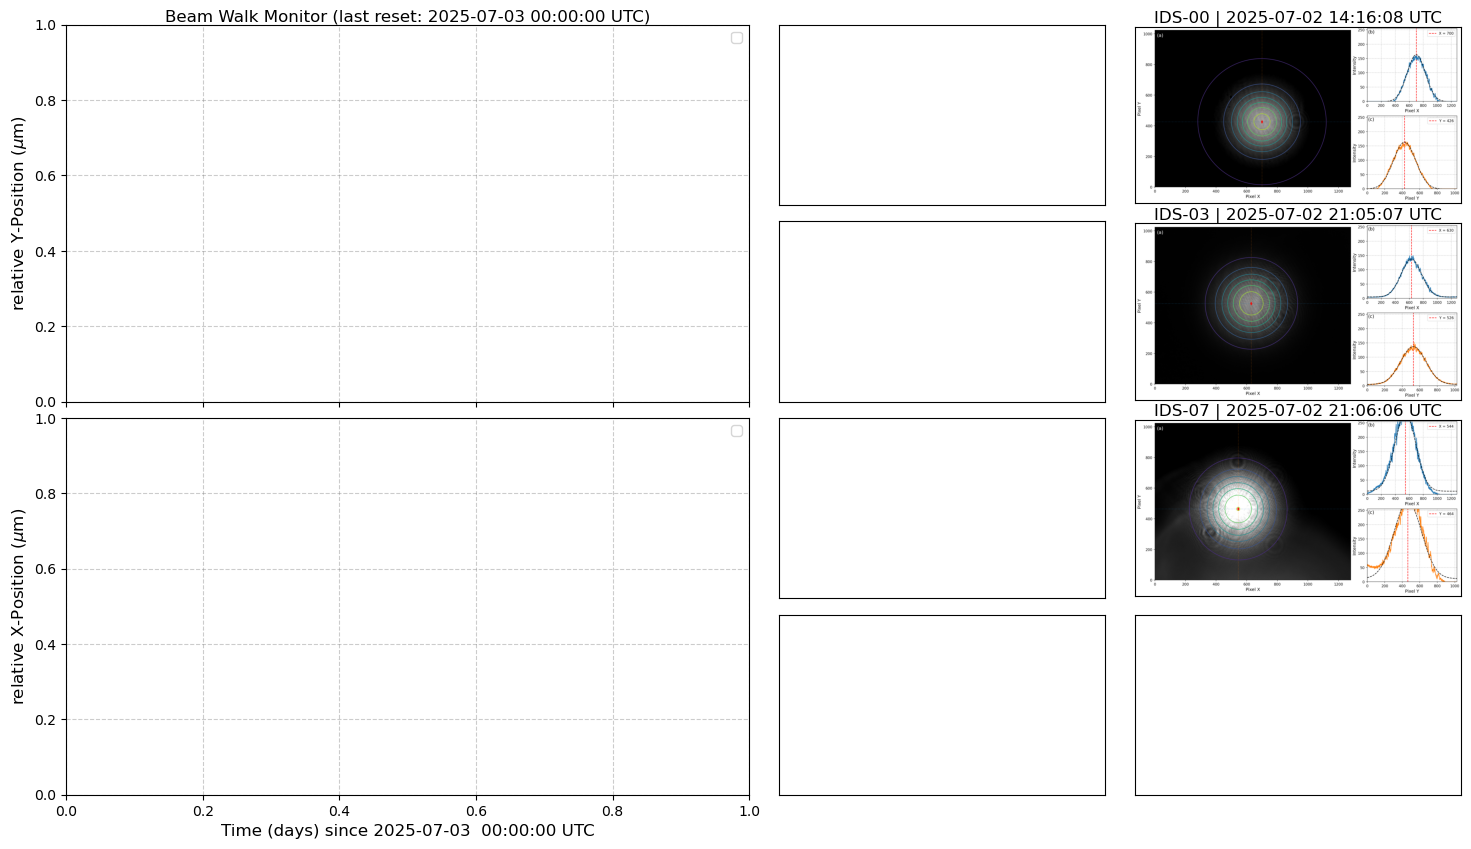

In [17]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"html_beamwalk.png", format="png", dpi=150, bbox_inches='tight')

del fig